## Force Memory Analysis

The force correlations at a fixed reference time point $t$ between all trajectories at a second time step $\tau$ are expressed as:

$$
\begin{align}
C_t(\tau) = \left<\delta f_c(t)\delta f_c(\tau)\right>_N
\end{align}
$$

with $\left<...\right>_N$ the mean over all $N$ trajectories and $\delta f_c(t')=f_c(t')-\left<f_c(t')\right>_N$ the constraint force $f_c$ at any given point in time $t'$ minus the average of all constraint forces at that time point.

This analysis allows to gain insight into correlations and time scales of all other (aka \"bath\") degrees of freedom that are orthogonal to the pulling coordinate and thus allow insights into, e.g., hydration sphere water dynamics and protein conformational changes. In the framework of dcTMD, $C_t(\tau)$ corresponds to the so-called Memory Kernel. See Wolf, Stock, JCTC 2018, 14, 6715 and Post, Wolf, Stock, JCTC 2022, 18, 2816 for further details and examples for such analyses.

Please note: the convergence of $C_t(\tau)$ is very poor. We advise some soft Gaussian smoothing of the autocorrelation function to check for a specific structure. 

We start by introducing the general concept with dummy sinoid data and continue with real trajectories.

### Sinoid Data

In [1]:

import numpy as np
import matplotlib.pyplot as plt

N = 100  # number of trajectories
length_data = 3500  # nuber of time steps

# create a mock delta_force_array with sine functions:
force_array = np.array([
    np.sin(np.linspace(0, 2 * np.pi, length_data) + phase)
    for phase in np.linspace(0, 0.5 * np.pi, N)
])

print(force_array.shape)
force_mean = np.mean(force_array, axis=0)

# calculate $\delta f(t) = f(t) - \left< f(t) \right>_N$
delta_force_array = force_array - force_mean



(100, 3500)


In [ ]:
# define x and y labels for plotting
xlabel = r'time step $\tau$'
ylabel = r'$C_t({\tau}) = \left\langle\delta f(t)\delta f(\tau)\right\rangle_N$'
legend_title = 'ref. time step / position'

plot example force data

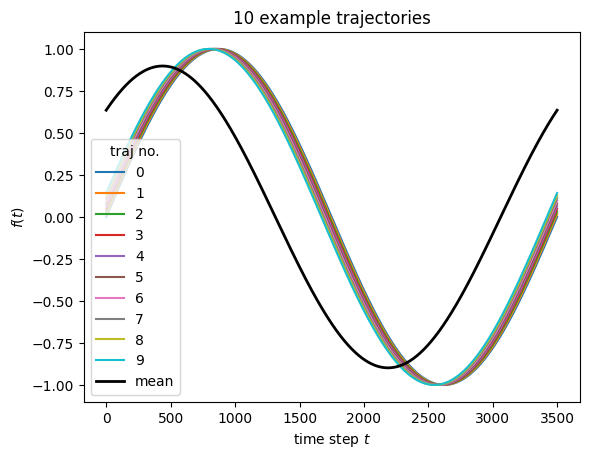

In [3]:
x = np.linspace(0, 3.5-0.001, length_data)

fig, ax = plt.subplots()
for n in range(10):
    ax.plot(force_array[n], label=f'{n}')
ax.set(
    xlabel=r'time step $t$',
    ylabel=r'$f(t)$',
    title='10 example trajectories'
)
ax.plot(force_mean, color='black', linewidth=2, label='mean')
plt.legend(title='traj no.')
plt.show()



plot $\delta f(t)$

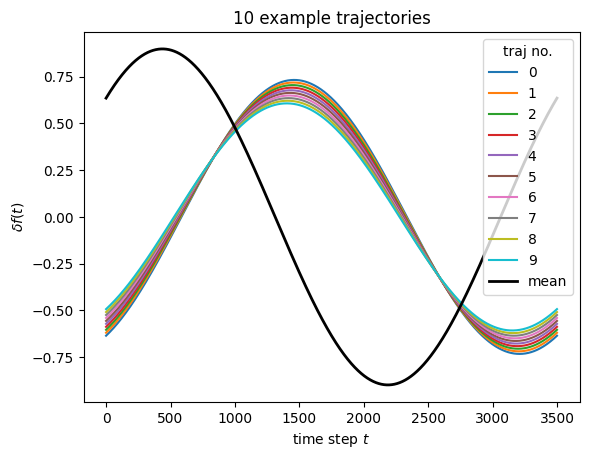

In [4]:
fig, ax = plt.subplots()
for n in range(10):
    ax.plot(delta_force_array[n], label=f'{n}')
ax.plot(force_mean, color='black', linewidth=2, label='mean')
ax.set(
    xlabel=r'time step $t$',
    ylabel=r'$\delta f(t)$',
    title='10 example trajectories'
)
plt.legend(title='traj no.')
plt.show()

calculate memory at a given time index using the kernel_at_ndx function

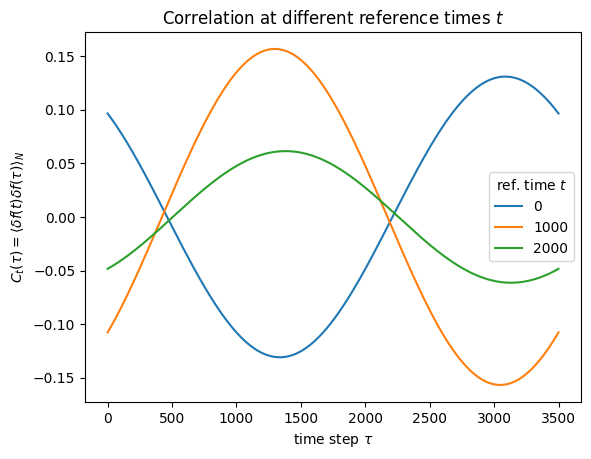

In [5]:
from dcTMD.dcTMD import ForceEstimator as fe

t_ndx_list = [0, 1000, 2000]
correlation_array = np.zeros((len(t_ndx_list), length_data))
for i, t_ndx in enumerate(t_ndx_list):
    correlation_array[i] = fe.kernel_at_ndx(delta_force_array, t_ndx)

fig, ax = plt.subplots()
for i in range(len(t_ndx_list)):
    ax.plot(correlation_array[i], label=t_ndx_list[i])
ax.set(
    xlabel=xlabel,
    ylabel=ylabel,
    title=r'Correlation at different reference times $t$'
)
plt.legend(title=r'ref. time $t$')
plt.show()


### Trajectory Data:

This analysis is usually done in addition to the $\Delta G$ and $\Gamma$ evaluation based on the ForceEstimator class. If you have read [dcTMD via Force](force.ipynb) you can skip the steps 0 and 1. 

### 0. load packages and define variables

In [6]:
import numpy as np
from dcTMD.dcTMD import ForceEstimator
from dcTMD.storing import ForceSet
import dcTMD

In [7]:
# define variables
velocity = 0.001
res = 10
verbose = True
temperature = 300

### 1. create a forceset instance 
To calculate free energy and friction estimates a forceset containing all the force time traces is needed.

#### I. an array containing the filenames is generated.
This can be done via the function dcTMD.io.load_pullf() which takes either a glob pattern or a file containing the pullf file names as argument.

In [8]:
# if the filesnames are stored in a file
pullf_files = '../../tests/testdata/pullf_filenames.dat'
# using a glob pattern / wildcard
pullf_files = '../../tests/testdata/*pullf.xvg'
# loading the filenames
filenames = dcTMD.io.load_pullf(pullf_files)

print(filenames)


file ../../tests/testdata/*pullf.xvg not found. using glob.glob(../../tests/testdata/*pullf.xvg)
['../../tests/testdata/t_middle_16_pullf.xvg', '../../tests/testdata/t_middle_26_pullf.xvg', '../../tests/testdata/t_middle_29_pullf.xvg', '../../tests/testdata/t_middle_32_pullf.xvg', '../../tests/testdata/t_middle_19_pullf.xvg', '../../tests/testdata/t_middle_03_pullf.xvg', '../../tests/testdata/t_middle_04_pullf.xvg', '../../tests/testdata/t_middle_05_pullf.xvg', '../../tests/testdata/t_middle_25_pullf.xvg', '../../tests/testdata/t_middle_31_pullf.xvg', '../../tests/testdata/t_middle_21_pullf.xvg', '../../tests/testdata/t_middle_17_pullf.xvg', '../../tests/testdata/t_middle_24_pullf.xvg', '../../tests/testdata/t_middle_09_pullf.xvg', '../../tests/testdata/t_middle_28_pullf.xvg', '../../tests/testdata/t_middle_30_pullf.xvg', '../../tests/testdata/t_middle_34_pullf.xvg', '../../tests/testdata/t_middle_01_pullf.xvg']


#### II. the forceset is created
by creating a ForceSet instance which is fitted with the filenames. 

In [9]:
# create ForceSet instance
forceset = ForceSet(velocity=velocity,
                  resolution=res,
                  verbose=verbose,
                  )
# fit/fill workset
forceset.fit(filenames)



Using ../../tests/testdata/t_middle_16_pullf.xvg to initialize arrays.
length of pullf file is 20001
reduced length is 2001


Loading force files: 100%|██████████| 18/18 [00:00<00:00, 138.31it/s]

Reading file ../../tests/testdata/t_middle_16_pullf.xvg
Reading file ../../tests/testdata/t_middle_26_pullf.xvg
Reading file ../../tests/testdata/t_middle_29_pullf.xvg
Reading file ../../tests/testdata/t_middle_32_pullf.xvg
Reading file ../../tests/testdata/t_middle_19_pullf.xvg
Reading file ../../tests/testdata/t_middle_03_pullf.xvg
Reading file ../../tests/testdata/t_middle_04_pullf.xvg
Reading file ../../tests/testdata/t_middle_05_pullf.xvg
Reading file ../../tests/testdata/t_middle_25_pullf.xvg
Reading file ../../tests/testdata/t_middle_31_pullf.xvg
Reading file ../../tests/testdata/t_middle_21_pullf.xvg
Reading file ../../tests/testdata/t_middle_17_pullf.xvg
Reading file ../../tests/testdata/t_middle_24_pullf.xvg
Reading file ../../tests/testdata/t_middle_09_pullf.xvg
Reading file ../../tests/testdata/t_middle_28_pullf.xvg
Reading file ../../tests/testdata/t_middle_30_pullf.xvg
Reading file ../../tests/testdata/t_middle_34_pullf.xvg
Reading file ../../tests/testdata/t_middle_01_pu

ForceSet(resolution=10, velocity=0.001, verbose=True)

### III. derive estimates from the forceset

1. instantiate a ForceEstimator instance
2. fit ForceEstimator instance with previously created forceset

When the ForceEstimator is fit with the forceset the delta_force_array is created

In [10]:
forceestimator = ForceEstimator(temperature)
forceestimator.fit(forceset)

ForceEstimator(temperature=300)

### 2. calculate correlations at given reference time steps 

There are two options for the time steps at which the correlation is calculated.
1. specify the indices of the time steps with index
2. calculate the correlation every ndx_striding time steps

CAUTION: calculating the correlations is very memory consuming.

In [11]:
index = np.array((0, 1000, 2000))
correlation_at_given_ndx = forceestimator.memory_kernel(index=index)

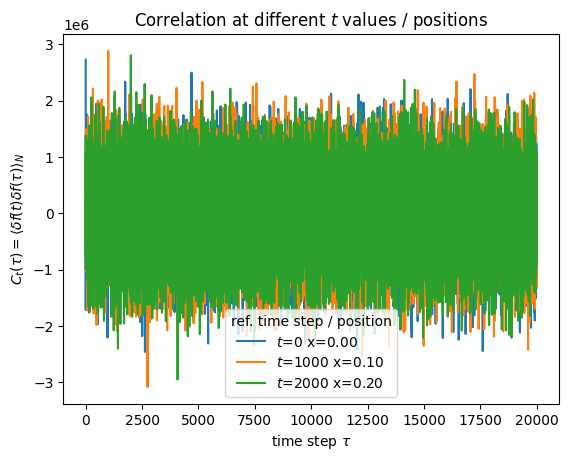

In [12]:
fig, ax = plt.subplots()
for (c, n) in zip(correlation_at_given_ndx, index):
    plt.plot(c, label=fr'$t$={n} x={forceset.position_[n]:.2f}')
plt.legend(title=legend_title)
ax.set(
    xlabel=xlabel,
    ylabel=ylabel,
    title=r'Correlation at different $t$ values / positions'
)
#plt.savefig('forceforce_correlation_2dplot.png', dpi=300)
plt.show()

  Since the data is very noisy one can apply a Gaussian filter to the data  

Applying Gaussian filter with sigma=1000 time steps (~0.10 nm)


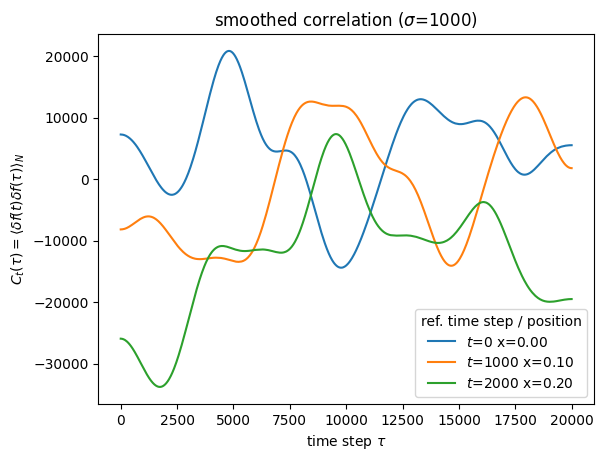

In [13]:
from scipy.ndimage import gaussian_filter1d

filter_width = 1000
filter_width_in_nm = filter_width * forceset.position_[1]

print(f'Applying Gaussian filter with sigma={filter_width} time steps (~{filter_width_in_nm:.2f} nm)')

fig, ax = plt.subplots()
for (c, n) in zip(correlation_at_given_ndx, index):
    data = gaussian_filter1d(c, sigma=filter_width)
    plt.plot(data, label=fr'$t$={n} x={forceset.position_[n]:.2f}')
plt.legend(title=legend_title)
ax.set(
    xlabel=xlabel,
    ylabel=ylabel,
    title=rf'smoothed correlation ($\sigma$={filter_width})'
)
#plt.savefig('forceforce_correlation_2dplot.png', dpi=300)
plt.show()



2. calculate correlation every ndx_striding=1000 time steps

In [14]:
ndx_striding = 5000
striding_in_nm = ndx_striding * forceset.position_[1]
print(f'Calculating correlation every ndx_striding={ndx_striding} time steps (~{striding_in_nm:.2f} nm)')
forceestimator.memory_kernel(
    ndx_striding=ndx_striding
)
correlation_at_ndx_striding = forceestimator.memory_kernel_
index = forceestimator.memory_kernel_index_

Calculating correlation every ndx_striding=5000 time steps (~0.50 nm)
create index with ndx_resolution


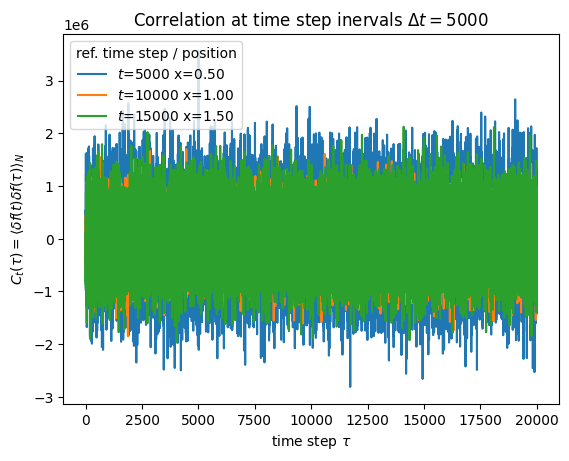

In [15]:

fig, ax = plt.subplots()
for i, (data, n) in enumerate(zip(correlation_at_ndx_striding, index)):
    plt.plot(data, label=fr'$t$={n} x={forceset.position_[n]:.2f}')
    if i>=10:
        break
plt.legend(title=legend_title)
ax.set(
    xlabel=xlabel,
    ylabel=ylabel,
    title=rf'Correlation at time step inervals $\Delta t= ${ndx_striding}'
)
plt.show()


Applying Gaussian filter with sigma=1000 time steps (~0.10 nm)


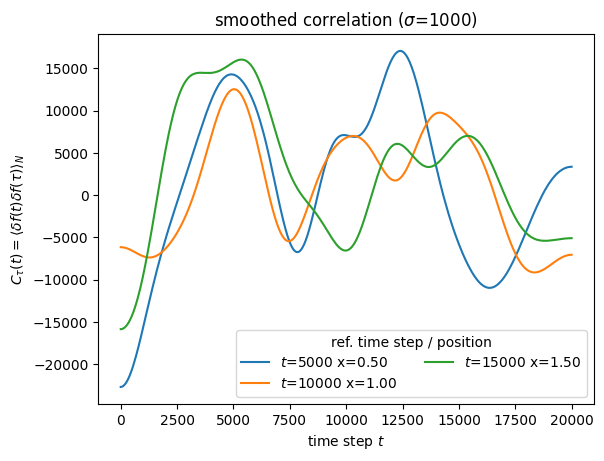

In [16]:
# here we can reuse filter_width defined earlier

filter_width_in_nm = filter_width * forceset.position_[1]
print(f'Applying Gaussian filter with sigma={filter_width} time steps (~{filter_width_in_nm:.2f} nm)')


fig, ax = plt.subplots()
for i, (data, n) in enumerate(zip(correlation_at_ndx_striding, index)):
    data = gaussian_filter1d(data, sigma=filter_width)
    plt.plot(
        data,
        label=fr'$t$={n} x={forceset.position_[n]:.2f}'
    )
    if i>=8:
        break
plt.legend(title=legend_title, loc='lower right', ncol=2)
ax.set(
    xlabel=r'time step $t$',
    ylabel=r'$C_{\tau}(t) = \left\langle\delta f(t)\delta f(\tau)\right\rangle_N$',
    title=rf'smoothed correlation ($\sigma$={filter_width})'
)
plt.show()

#### 3D plots
The function forceforce_correlation_3dplot creates a 3D plot to visualize the correlation between forces over time. It allows for optional smoothing and can display specific positions on the z-axis.

In [17]:
# create a 3D plot with the lag time on the x axis
def forceforce_correlation_3dplot(
    index, correlation_set,
    position=None,
    smoothing=None,
    addplane=False
):
    """
    Create a 3D plot of the force-force correlation function.
    Parameters
    ----------
    index :
        Indices at which the correlation is calculated.
    correlation_set :
        shape: (len(index), length_data)
        NaN are set to zero
    """
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(r'ref. time step $t$')
    ax.set_zlabel(ylabel)
    
    x_plane = np.linspace(0, len(correlation_set[0]), len(correlation_set[0]))
    y_plane = np.linspace(min(index), max(index), len(index))
    if position is not None:
        y_plane = np.linspace(
            position[min(index)],
            position[max(index)],
            len(index)
        )
    X_plane, Y_plane = np.meshgrid(x_plane, y_plane)
    Z_plane = np.zeros_like(X_plane)


    for i, ndx in enumerate(index):
        if smoothing is not None:
            x = gaussian_filter1d(correlation_set[i], sigma=smoothing)
        else:
            x = correlation_set[i]
        y = np.arange(len(x))
        if position is not None:
            z = position[ndx]
            ax.set_ylabel(r'$x$ [nm]')

        else:
            z = ndx
        ax.plot(y, x, zs=z, zdir='y', label=f'lag {ndx}')
    
    if addplane:
        # Create a semi-transparent plane at z=0
        ax.plot_surface(X_plane, Y_plane, Z_plane, alpha=0.5, color='gray')
    #ax.set_ylim(ax.get_ylim()[::-1])  # Reverse the y-axis limits



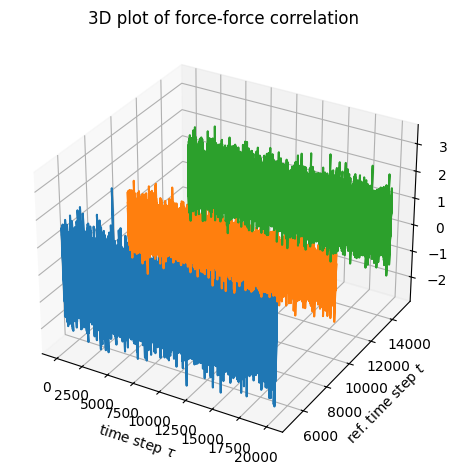

In [18]:
forceforce_correlation_3dplot(
    index,
    correlation_at_ndx_striding,
)
plt.title('3D plot of force-force correlation')
plt.tight_layout()
plt.show()



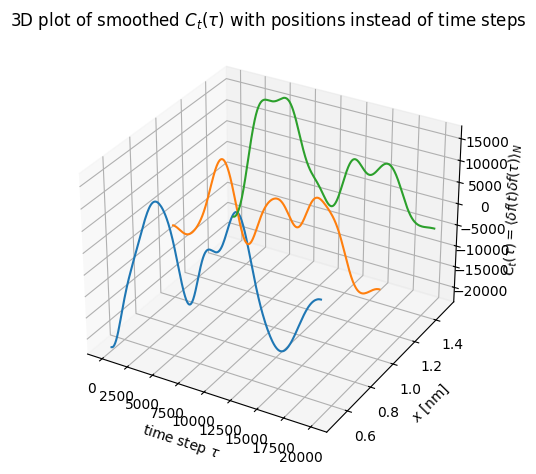

In [19]:
forceforce_correlation_3dplot(
    index,
    correlation_at_ndx_striding,
    position=forceset.position_,
    smoothing=filter_width
)
plt.title(r'3D plot of smoothed $C_t(\tau)$ with positions instead of time steps')
plt.tight_layout()
plt.show()


